In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()

In [3]:


# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [72]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 5]) torch.Size([182580])
torch.Size([22767, 5]) torch.Size([22767])
torch.Size([22799, 5]) torch.Size([22799])


In [73]:
n_embed = 10
n_hidden = 200



g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g).to(device) 
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).to(device) * (5/3)/((n_embed * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g).to(device) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device) * 0.01
b2 = torch.randn(vocab_size, generator=g).to(device) * 0

bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)
bnmean_running = torch.zeros((1, n_hidden)).to(device)
bnstd_running = torch.ones((1, n_hidden)).to(device)
parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [74]:
class Linear:

    def __init__(self, fan_in, fan_out, device, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g).to(device) / fan_in**0.5
        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, device, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # params
        self.gamma = torch.ones(dim).to(device)
        self.beta = torch.zeros(dim).to(device)

        # running vals
        self.running_mean = torch.zeros(dim).to(device)
        self.running_var = torch.ones(dim).to(device)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + xmean * self.momentum
                self.running_var = (1 - self.momentum) * self.running_var + xvar * self.momentum
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g).to(device)
layers = [
    Linear(n_embed * block_size, n_hidden, device), BatchNorm1d(n_hidden, device), Tanh(),
    Linear(n_hidden, n_hidden, device), BatchNorm1d(n_hidden, device), Tanh(),
    Linear(n_hidden, n_hidden, device), BatchNorm1d(n_hidden, device), Tanh(),
    Linear(n_hidden, n_hidden, device), BatchNorm1d(n_hidden, device), Tanh(),
    Linear(n_hidden, n_hidden, device), BatchNorm1d(n_hidden, device), Tanh(),
    Linear(n_hidden, vocab_size, device), BatchNorm1d(vocab_size, device), 
]


with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear): 
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

49551


In [75]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [76]:
lri, lossi, stepi = [], [], []
lr = 0.01
max_steps = 10000
batch_size = 32
ud = []

for i in range(max_steps):

    # randomly select a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters: 
        p.grad = None
    loss.backward()

    # sgd update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(i, loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i > 1000: break




0 3.3346402645111084
1000 2.4759879112243652


mean: 0.00018180243205279112, std: 0.6291795969009399, saturation: 0.03125
mean: 0.0028131287544965744, std: 0.6467278003692627, saturation: 0.02187499962747097
mean: 0.004482456482946873, std: 0.6426516175270081, saturation: 0.022812500596046448
mean: 0.0036562541499733925, std: 0.6450161933898926, saturation: 0.020625000819563866
mean: -0.006752970162779093, std: 0.6551706194877625, saturation: 0.011874999850988388


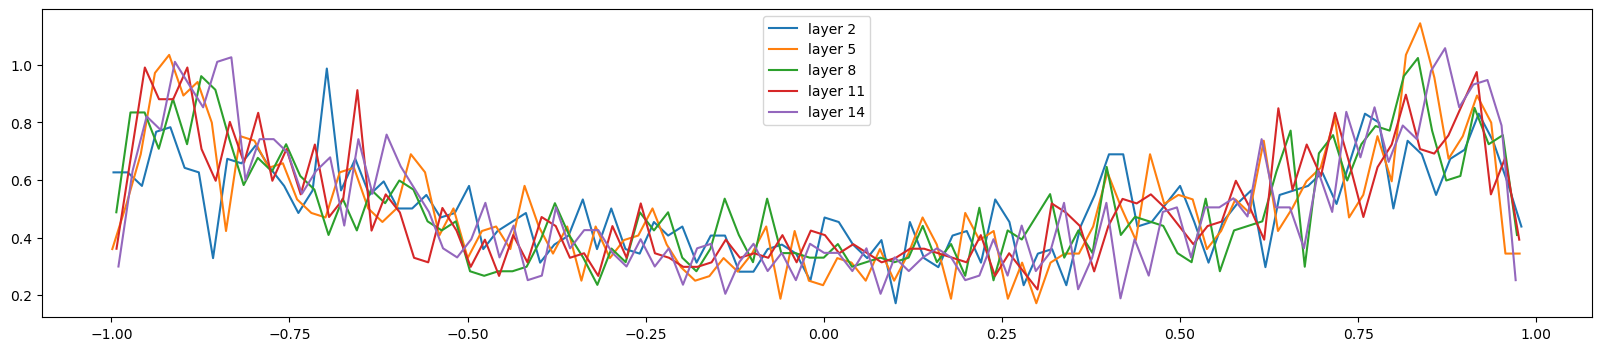

In [77]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.cpu()
        print(f'mean: {t.mean()}, std: {t.std()}, saturation: {(t.abs() > 0.97).float().mean()}')
        hy, hx = torch.histogram(t, density=True)
        legends.append(f'layer {i}')
        plt.plot(hx[:-1].detach(), hy.detach())
plt.legend(legends);

mean: -2.0954758761515535e-11, std: 0.0028457683511078358, saturation: 0.0
mean: 0.0, std: 0.0024807509034872055, saturation: 0.0
mean: -8.149072562579907e-12, std: 0.002175810281187296, saturation: 0.0
mean: 1.222360841018899e-11, std: 0.0021147949155420065, saturation: 0.0
mean: -6.984919153490976e-12, std: 0.0021594318095594645, saturation: 0.0


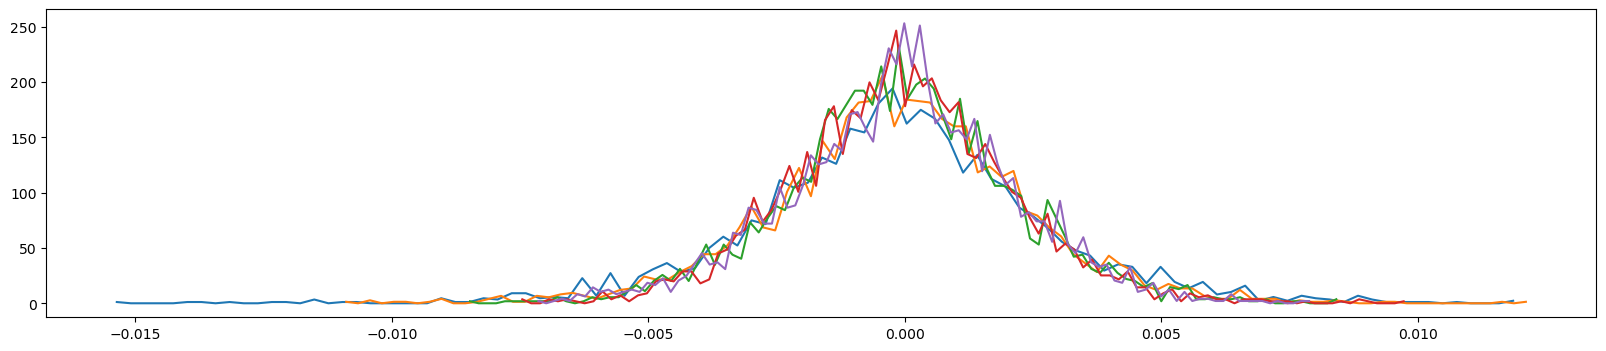

In [78]:

plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad.cpu()
        print(f'mean: {t.mean()}, std: {t.std()}, saturation: {(t.abs() > 0.97).float().mean()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

mean: -2.207579397062176e-10, std: 0.007578285411000252, saturation: 0.0
mean: 4.7961599193513393e-05, std: 0.0065939705818891525, saturation: 0.0
mean: -4.45021505584009e-05, std: 0.0054230159148573875, saturation: 0.0
mean: -3.9995546103455126e-05, std: 0.004850422497838736, saturation: 0.0
mean: -5.6905464589362964e-05, std: 0.004288912285119295, saturation: 0.0
mean: -1.7930353351403028e-05, std: 0.004064581356942654, saturation: 0.0
mean: 4.242842987878248e-05, std: 0.007783715147525072, saturation: 0.0


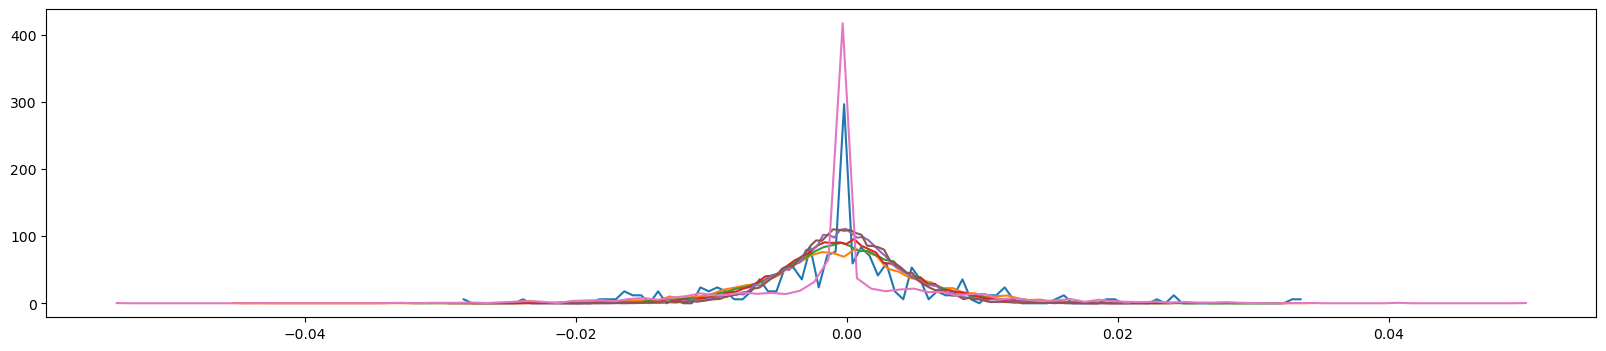

In [79]:

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad.cpu()
    if p.ndim == 2:
        print(f'mean: {t.mean()}, std: {t.std()}, saturation: {(t.abs() > 0.97).float().mean()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

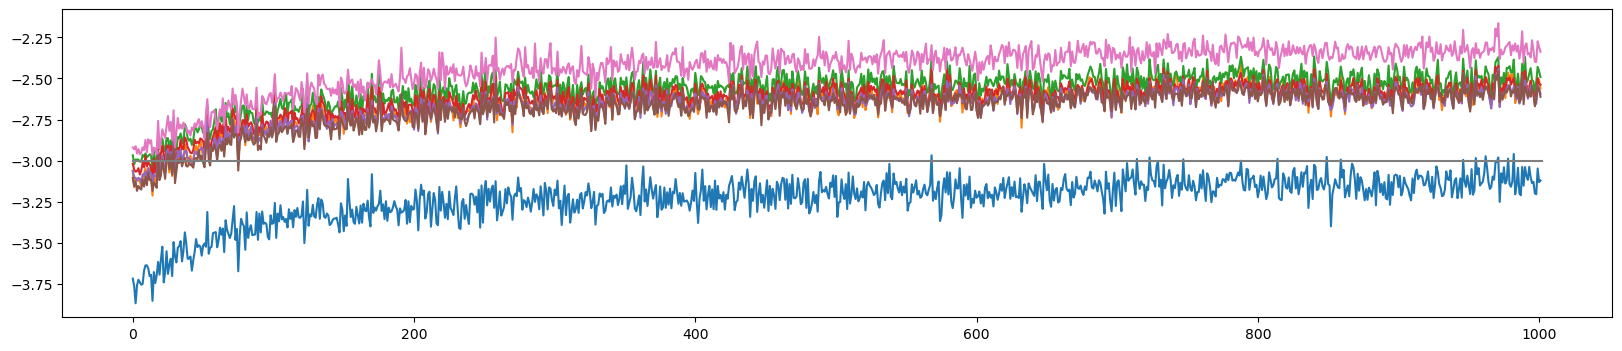

In [80]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
# roughly, ratio of updates to data should be about 1e-3
plt.plot([0, len(ud)], [-3, -3], '')

In [81]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [9]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# + b1
    # batch norm
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnmean_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2092549800872803
val 2.2253618240356445


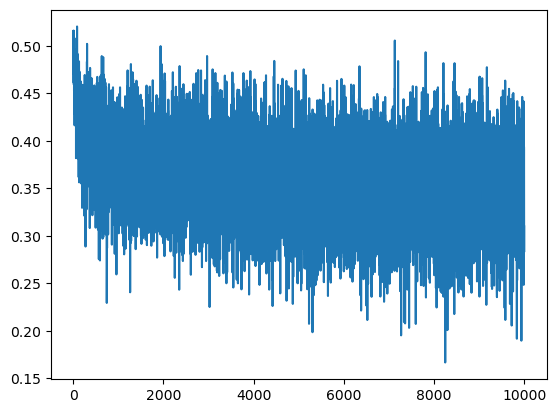

In [32]:
plt.plot(stepi, lossi)

In [17]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).to(device).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))



grayth.
jotia.
vitarel.
daely.
rwiz.
rosoniels.
diley.
xojeinel.
cilro.
lilyya.
ryamanevle.
korbona.
kobialeent.
satenes.
horey.
khyana.
oliyna.
venia.
remie.
narmikly.


(array([232., 147., 104., 128., 114., 107.,  97.,  89., 112., 107., 101.,
        102., 108.,  95., 111., 136., 133., 119., 103., 153., 111., 139.,
        160., 159., 147., 138., 172., 138., 148., 140., 117., 134., 122.,
        124., 128.,  98., 136., 109., 104., 101.,  92.,  96., 105., 127.,
        106., 127., 105., 144., 163., 312.]),
 array([-9.99885738e-01, -9.59888110e-01, -9.19890482e-01, -8.79892855e-01,
        -8.39895227e-01, -7.99897599e-01, -7.59899971e-01, -7.19902344e-01,
        -6.79904716e-01, -6.39907088e-01, -5.99909461e-01, -5.59911833e-01,
        -5.19914205e-01, -4.79916577e-01, -4.39918950e-01, -3.99921322e-01,
        -3.59923694e-01, -3.19926066e-01, -2.79928439e-01, -2.39930811e-01,
        -1.99933183e-01, -1.59935555e-01, -1.19937928e-01, -7.99403000e-02,
        -3.99426723e-02,  5.49554825e-05,  4.00525832e-02,  8.00502110e-02,
         1.20047839e-01,  1.60045466e-01,  2.00043094e-01,  2.40040722e-01,
         2.80038350e-01,  3.20035977e-01,  3.60033

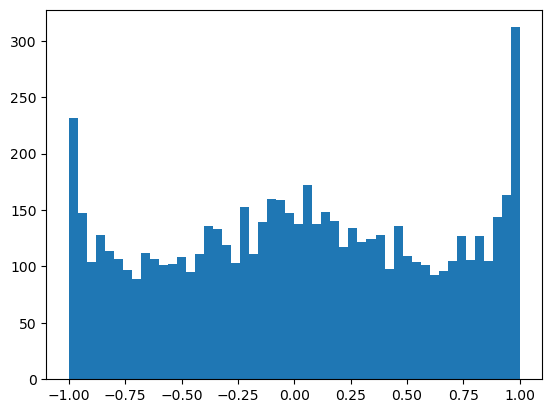

In [13]:


# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')
plt.hist(h.view(-1).tolist(), 50)


(array([  1.,   1.,   1.,   2.,   3.,   2.,   5.,  11.,  24.,  20.,  48.,
         58.,  69., 112., 155., 186., 191., 235., 298., 312., 378., 418.,
        468., 457., 401., 350., 386., 309., 326., 260., 190., 150., 166.,
        125.,  98.,  66.,  36.,  24.,  19.,  15.,   7.,   5.,   3.,   2.,
          3.,   0.,   1.,   0.,   0.,   3.]),
 array([-24.9390564 , -23.86091011, -22.78276382, -21.70461754,
        -20.62647125, -19.54832497, -18.47017868, -17.39203239,
        -16.31388611, -15.23573982, -14.15759354, -13.07944725,
        -12.00130096, -10.92315468,  -9.84500839,  -8.76686211,
         -7.68871582,  -6.61056953,  -5.53242325,  -4.45427696,
         -3.37613068,  -2.29798439,  -1.2198381 ,  -0.14169182,
          0.93645447,   2.01460075,   3.09274704,   4.17089333,
          5.24903961,   6.3271859 ,   7.40533218,   8.48347847,
          9.56162476,  10.63977104,  11.71791733,  12.79606361,
         13.8742099 ,  14.95235619,  16.03050247,  17.10864876,
         18.186795

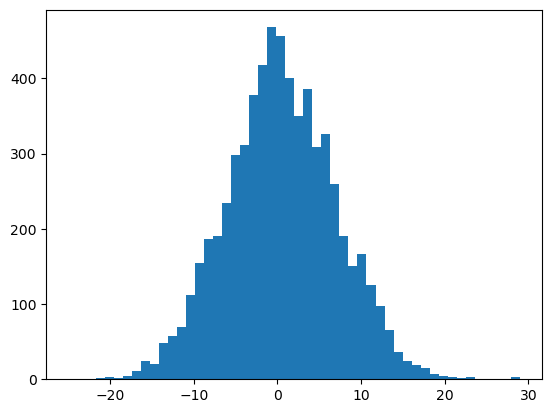

In [21]:

plt.hist(hpreact.view(-1).tolist(), 50)